In [1]:
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef
from statistics import stdev, variance, mean

In [2]:
mat_client=np.load("../data/PTT5XLU50_human_client.npy", allow_pickle=True)
mat_nonLLPS=np.load("../data/PTT5XLU50_human_nonllps.npy", allow_pickle=True)
mat_scaffold=np.load("../data/PTT5XLU50_human_scaffold.npy", allow_pickle=True)
list_client=list(mat_client.item().values())
list_nonLLPS=list(mat_nonLLPS.item().values())
list_scaffold=list(mat_scaffold.item().values())

In [3]:
class Benchmark_model():
    def __init__(self,x:np.array, y:np.array, model):
        self.x=x
        self.y=y
        self.model=model
        
    def cv(self, x, y):
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
        scores_rocauc=[]
        scores_prauc=[]
        scores_mcc=[]
        tprs = []
        mean_fpr = np.linspace(0, 1, 1000)
        
        for train,test in cv.split(x, y):
            self.model.fit(x[train],y[train])
            y_pred_proba=model.predict_proba(x[test])[:,1]
            y_pred=model.predict(x[test])
            fpr, tpr, thresholds = roc_curve(y[test], y_pred_proba)
            roc_auc=auc(fpr,tpr)
            precision, recall, thresholds = precision_recall_curve(y[test], y_pred_proba)
            pr_auc = auc(recall, precision)
            mcc=matthews_corrcoef(y[test], y_pred)
            
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            
            scores_rocauc.append(roc_auc)
            scores_prauc.append(pr_auc)
            scores_mcc.append(mcc)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        return mean_tpr, mean(scores_rocauc), mean(scores_prauc), mean(scores_mcc)
    
    def under_sampling(self):
        x=self.x
        y=self.y
        x_ture=x[y==True]
        x_false=x[y==False]
        y_ture=y[y==True]
        y_false=y[y==False]
        positive_n=len(y_ture)
        negative_n=len(y_false)
        random_index=np.random.randint(0,negative_n,positive_n)  
        x_false_u=x_false[random_index]
        y_false_u=y_false[random_index]
        return np.concatenate([x_ture, x_false_u]), np.concatenate([y_ture, y_false_u])
    
    def run(self):
        self.tprs=[]
        self.rocaucs=[]
        self.praucs=[]
        self.mccs=[]
        for i in range(10):
            x,y=self.under_sampling()
            tpr, rocauc, prauc, mcc = self.cv(x,y)
            self.tprs.append(tpr)
            self.rocaucs.append(rocauc)
            self.praucs.append(prauc)
            self.mccs.append(mcc)
            print("{}/10 done".format(i+1))
        print("ROC AUC {:.3f}±{:.3f}".format(mean(self.rocaucs), stdev(self.rocaucs)))
        print("PR AUC {:.3f}±{:.3f}".format(mean(self.praucs), stdev(self.praucs)))
        print("MCC {:.3f}±{:.3f}".format(mean(self.mccs), stdev(self.mccs)))

In [4]:
def display_auc(benchmark, title=""):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    fpr = np.linspace(0, 1, 1000)
    for i, tpr in enumerate(benchmark.tprs):
        ax.plot(
        fpr,
        tpr,
        color="gray",
        lw=1,
        alpha=0.3
        )
    mean_tpr = np.mean(benchmark.tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc=mean(benchmark.rocaucs)
    std_auc=stdev(benchmark.rocaucs)
    ax.plot(
        fpr,
        mean_tpr,
        color="b",
        label=r"PhaseTransPred (AUC = %0.3f $\pm$ %0.3f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", alpha=0.3)
    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title=title
    )
    ax.set_xlabel("False positive rate", fontsize=13)
    ax.set_ylabel("True positive rate", fontsize=13)
    ax.legend(loc="lower right")
    plt.show()

In [5]:
x=np.array(list_client+list_nonLLPS)
y=np.array([True]*len(list_client) + [False]*len(list_nonLLPS))
model=make_pipeline(StandardScaler(), SVC(class_weight="balanced", probability=True))

In [6]:
benchmark_svm=Benchmark_model(x,y,model)
benchmark_svm.run()

0/10 done
1/10 done
2/10 done
3/10 done
4/10 done
5/10 done
6/10 done
7/10 done
8/10 done
9/10 done
ROC AUC 0.842±0.005
PR AUC 0.833±0.008
MCC 0.538±0.009


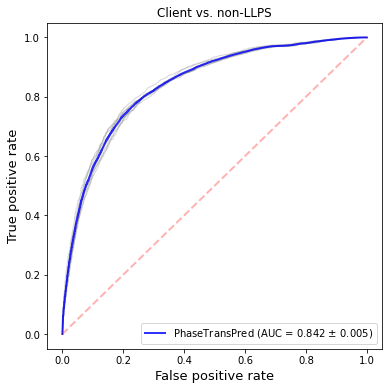

In [7]:
display_auc(benchmark_svm, "Client vs. non-LLPS")

In [8]:
x_scaffold_vs_non=np.array(list_scaffold+list_nonLLPS)
y_scaffold_vs_non=np.array([True]*len(list_scaffold) + [False]*len(list_nonLLPS))
model=make_pipeline(StandardScaler(), SVC(class_weight="balanced", probability=True))
benchmark_svm_scaffold_vs_non=Benchmark_model(x_scaffold_vs_non,y_scaffold_vs_non,model)
benchmark_svm_scaffold_vs_non.run()

0/10 done
1/10 done
2/10 done
3/10 done
4/10 done
5/10 done
6/10 done
7/10 done
8/10 done
9/10 done
ROC AUC 0.910±0.020
PR AUC 0.922±0.021
MCC 0.686±0.062


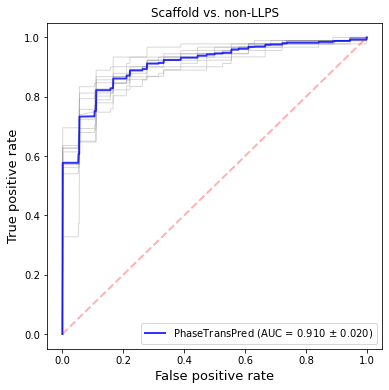

In [9]:
display_auc(benchmark_svm_scaffold_vs_non, "Scaffold vs. non-LLPS")

In [10]:
x_scaffold_vs_client=np.array(list_scaffold+list_client)
y_scaffold_vs_client=np.array([True]*len(list_scaffold) + [False]*len(list_client))
model=make_pipeline(StandardScaler(), SVC(class_weight="balanced", probability=True))
benchmark_svm_scaffold_vs_client=Benchmark_model(x_scaffold_vs_client,y_scaffold_vs_client,model)
benchmark_svm_scaffold_vs_client.run()

0/10 done
1/10 done
2/10 done
3/10 done
4/10 done
5/10 done
6/10 done
7/10 done
8/10 done
9/10 done
ROC AUC 0.775±0.038
PR AUC 0.777±0.045
MCC 0.422±0.066


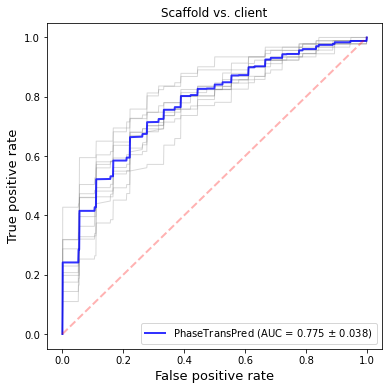

In [11]:
display_auc(benchmark_svm_scaffold_vs_client, "Scaffold vs. client")